### Distilling the Knowledge in a Neural Network

https://arxiv.org/pdf/1503.02531.pdf

In [8]:
from importlib import reload
import models
reload(models)
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
import numpy as np

In [2]:
batch_size = 1280
num_classes = 10
epochs = 60

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = dict()
hist = dict()
score = dict()
preds = dict()

In [4]:
reload(models)
model['teacher'] = models.TeacherModel(input_shape, num_classes)

model['teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

W0924 07:49:01.770157 139843146409792 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0924 07:49:01.803303 139843146409792 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 07:49:01.810083 139843146409792 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0924 07:49:01.880390 139843146409792 deprecation_wrapper.py:119] From /home/acar/.virtualenvs/mask_rcnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. P

In [18]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.teacher.hdf5', 
                               verbose=1, save_best_only=True)

hist['teacher'] = model['teacher'].fit(x_train, y_train, batch_size=batch_size,
          epochs=40, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpointer])
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 3s 50us/step - loss: 0.0185 - acc: 0.9939 - val_loss: 0.0312 - val_acc: 0.9905

Epoch 00001: val_loss improved from inf to 0.03117, saving model to saved_models/weights.best.teacher.hdf5
Epoch 2/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0199 - acc: 0.9936 - val_loss: 0.0297 - val_acc: 0.9913

Epoch 00002: val_loss improved from 0.03117 to 0.02974, saving model to saved_models/weights.best.teacher.hdf5
Epoch 3/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0184 - acc: 0.9938 - val_loss: 0.0291 - val_acc: 0.9918

Epoch 00003: val_loss improved from 0.02974 to 0.02914, saving model to saved_models/weights.best.teacher.hdf5
Epoch 4/60
60000/60000 [==============================] - 3s 51us/step - loss: 0.0174 - acc: 0.9943 - val_loss: 0.0307 - val_acc: 0.9906

Epoch 00004: val_loss did not improve from 0.02914
Epoch 5/60
60000/6

KeyboardInterrupt: 

In [19]:
model['teacher'].load_weights('saved_models/weights.best.teacher.hdf5')
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['teacher'][-1])*len(y_test))
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.028358562216590052
Test accuracy: 0.9916
Test errors: 83


In [23]:
reload(models)
model['soft_teacher'] = models.SoftTeacherModel(input_shape, num_classes, l1=0.1, l2=0.05, b=3)

model['soft_teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.soft_teacher.hdf5', 
                               verbose=1, save_best_only=True)

hist['soft_teacher'] = model['soft_teacher'].fit(x_train, y_train, batch_size=batch_size,
          epochs=40, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpointer])
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 9s 153us/step - loss: 1.4740 - acc: 0.7936 - val_loss: 1.1822 - val_acc: 0.9606

Epoch 00001: val_loss improved from inf to 1.18222, saving model to saved_models/weights.best.soft_teacher.hdf5
Epoch 2/40
60000/60000 [==============================] - 10s 170us/step - loss: 1.2273 - acc: 0.9492 - val_loss: 1.1449 - val_acc: 0.9780

Epoch 00002: val_loss improved from 1.18222 to 1.14491, saving model to saved_models/weights.best.soft_teacher.hdf5
Epoch 3/40
60000/60000 [==============================] - 11s 182us/step - loss: 1.1940 - acc: 0.9663 - val_loss: 1.1317 - val_acc: 0.9817

Epoch 00003: val_loss improved from 1.14491 to 1.13169, saving model to saved_models/weights.best.soft_teacher.hdf5
Epoch 4/40
60000/60000 [==============================] - 13s 222us/step - loss: 1.1768 - acc: 0.9732 - val_loss: 1.1244 - val_acc: 0.9836

Epoch 00004: val_loss improved from 1.13169 to 

In [25]:
model['soft_teacher'].load_weights('saved_models/weights.best.soft_teacher.hdf5')
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['soft_teacher'][-1])*len(y_test))
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.6754869379997254
Test accuracy: 0.9927
Test errors: 72


In [28]:
reload(models)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student.hdf5', 
                               verbose=1, save_best_only=True)

model['student'] = models.StudentModel(input_shape, num_classes)

model['student'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

hist['student'] = model['student'].fit(x_train, y_train, batch_size=batch_size,
          epochs=40, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpointer])
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.4492 - acc: 0.8732 - val_loss: 0.1869 - val_acc: 0.9458

Epoch 00001: val_loss improved from inf to 0.18690, saving model to saved_models/weights.best.student.hdf5
Epoch 2/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.1525 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9625

Epoch 00002: val_loss improved from 0.18690 to 0.12654, saving model to saved_models/weights.best.student.hdf5
Epoch 3/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.0966 - acc: 0.9718 - val_loss: 0.0924 - val_acc: 0.9715

Epoch 00003: val_loss improved from 0.12654 to 0.09244, saving model to saved_models/weights.best.student.hdf5
Epoch 4/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.0660 - acc: 0.9805 - val_loss: 0.0813 - val_acc: 0.9738

Epoch 00004: val_loss improved from 0.09244 to 0.08129, saving model 

In [29]:
model['student'].load_weights('saved_models/weights.best.student.hdf5')
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['student'][-1])*len(y_test))
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][-1])
print('Test errors:', n_errors)

Test loss: 0.058851640967372804
Test accuracy: 0.9818
Test errors: 181


# Knowledge Distilation

In [30]:
kd_gt = dict()
T = 20
kd_gt['t_train'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['t_test'] = model['teacher'].T_model(T).predict(x_test, verbose=1, batch_size=batch_size)
kd_gt['st_train'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['st_test'] = model['soft_teacher'].predict(x_test, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(kd_gt['t_train'], axis=-1).mean(), np.linalg.norm(kd_gt['st_train'], axis=-1).mean()

10000/10000 [==============================] - 0s 15us/step


(0.3970556, 0.61132103)

In [28]:
# import numpy as np
# from keras.activations import softmax

# def softmax_with_temp(x):
#     Temp = 1.0
#     e_x = np.exp((x - x.max(axis=1, keepdims=True))/Temp)
#     out = e_x / e_x.sum(axis=1, keepdims=True)
#     return out

# def soft_with_T(T=1):
#     def swt(x):
#         return softmax(x/T)
#     return swt

In [31]:
''' KNOWLEDGE DISTILLATION WITH REGULAR TEACHER (TEMPERATURE SOFTMAX) '''
reload(models)
model['student_'] = models.StudentModel(input_shape, num_classes, T=T, in_class=True)
model['student_'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[1., 1. / (T**2)],
                          optimizer='Adam',
                          metrics=['acc'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_.hdf5', 
                               verbose=1, save_best_only=True)

hist['student_'] = model['student_'].fit(x_train, [kd_gt['t_train'], y_train],
          batch_size=batch_size, epochs=200, verbose=1,
          validation_data=(x_test, [kd_gt['t_test'], y_test]), callbacks=[checkpointer])
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 31us/step - loss: 2.1679 - o1_loss: 2.1657 - o2_loss: 0.8971 - o1_acc: 0.7860 - o2_acc: 0.7859 - val_loss: 2.1178 - val_o1_loss: 2.1166 - val_o2_loss: 0.5106 - val_o1_acc: 0.9109 - val_o2_acc: 0.9087

Epoch 00001: val_loss improved from inf to 2.11784, saving model to saved_models/weights.best.student_.hdf5
Epoch 2/200
60000/60000 [==============================] - 1s 15us/step - loss: 2.1115 - o1_loss: 2.1105 - o2_loss: 0.3924 - o1_acc: 0.9276 - o2_acc: 0.9276 - val_loss: 2.1027 - val_o1_loss: 2.1020 - val_o2_loss: 0.2867 - val_o1_acc: 0.9468 - val_o2_acc: 0.9442

Epoch 00002: val_loss improved from 2.11784 to 2.10274, saving model to saved_models/weights.best.student_.hdf5
Epoch 3/200
60000/60000 [==============================] - 1s 16us/step - loss: 2.1020 - o1_loss: 2.1014 - o2_loss: 0.2301 - o1_acc: 0.9535 - o2_acc: 0.9534 - val_loss: 2.0970 - val_o1_loss: 2.0965 - val_

In [32]:
model['student_'].load_weights('saved_models/weights.best.student_.hdf5')
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_'][-1])*len(y_test))
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])
print('Test errors:', n_errors)

Test loss: 2.08525844039917
Test accuracy: 0.9879
Test errors: 121


In [35]:
''' SOFT TEACHER IN CLASS '''
reload(models)
from keras import callbacks

base_lr = 3e-3
decay = 0.99
optim = keras.optimizers.Adam(lr=base_lr)

model['student_st'] = models.StudentModel(input_shape, num_classes, T=1, in_class=True, l2=0.1, b=1.8)
model['student_st'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[0.1, 1.],
                          optimizer=optim,
                          metrics=['acc'])

def schedule(epoch):
    return base_lr * decay**(epoch)

#es = callbacks.EarlyStopping(monitor='val_o2_loss', mode='min', verbose=0, patience=30)
#mc = callbacks.ModelCheckpoint('best_student_st.h5', monitor='val_o2_acc', mode='max', verbose=0, save_best_only=True)
ls = callbacks.LearningRateScheduler(schedule)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.student_st.hdf5', 
                               verbose=1, save_best_only=True)

hist['student_st'] = model['student_st'].fit(x_train, [kd_gt['st_train'], y_train],
          batch_size=batch_size,
          epochs=200,
          verbose=1,
          validation_data=(x_test, [kd_gt['st_test'], y_test]),
          callbacks=[ls, checkpointer],
            )
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 3s 45us/step - loss: 0.6732 - o1_loss: 2.3035 - o2_loss: 0.4428 - o1_acc: 0.8687 - o2_acc: 0.8682 - val_loss: 0.3854 - val_o1_loss: 2.1934 - val_o2_loss: 0.1660 - val_o1_acc: 0.9667 - val_o2_acc: 0.9640

Epoch 00001: val_loss improved from inf to 0.38538, saving model to saved_models/weights.best.student_st.hdf5
Epoch 2/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.3521 - o1_loss: 2.1580 - o2_loss: 0.1363 - o1_acc: 0.9730 - o2_acc: 0.9726 - val_loss: 0.3398 - val_o1_loss: 2.1484 - val_o2_loss: 0.1249 - val_o1_acc: 0.9779 - val_o2_acc: 0.9755

Epoch 00002: val_loss improved from 0.38538 to 0.33975, saving model to saved_models/weights.best.student_st.hdf5
Epoch 3/200
60000/60000 [==============================] - 1s 16us/step - loss: 0.3117 - o1_loss: 2.1314 - o2_loss: 0.0985 - o1_acc: 0.9856 - o2_acc: 0.9851 - val_loss: 0.3240 - val_o1_loss: 2.1790 - 

In [36]:
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_st'][-1])*len(y_test))
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])
print('Test errors:', n_errors)

Test loss: 0.2815059720993042
Test accuracy: 0.9887
Test errors: 112


# Analysis

In [15]:
T = 20
preds['teacher'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
preds['soft_teacher'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(preds['teacher'], axis=-1).mean(), np.linalg.norm(preds['soft_teacher'], axis=-1).mean()

60000/60000 [==============================] - 1s 17us/step


(0.37410536, 0.60892314)

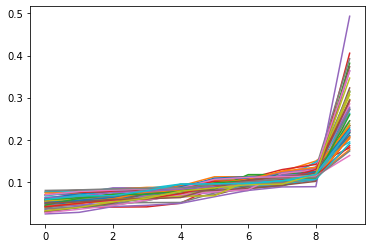

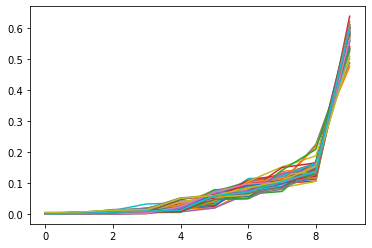

In [17]:
## Plot constrained softmax probabilities generated by the model

import matplotlib.pyplot as plt
ind = np.random.choice(len(preds['teacher']), 50)
plt.plot(np.sort(preds['teacher'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['soft_teacher']), 50)
plt.plot(np.sort(preds['soft_teacher'])[ind].T)
plt.show()

In [116]:
from collections import Counter

pairs = [(x[-1], x[-2]) for x in np.argsort(preds['teacher'])]
counts = Counter(pairs)
counts.most_common(20)

[((4, 9), 4173),
 ((3, 5), 3223),
 ((7, 9), 3030),
 ((9, 4), 2460),
 ((5, 3), 2348),
 ((6, 5), 2334),
 ((1, 4), 2230),
 ((2, 3), 2195),
 ((0, 2), 2080),
 ((6, 4), 2067),
 ((1, 7), 1982),
 ((5, 9), 1881),
 ((0, 6), 1759),
 ((8, 5), 1475),
 ((9, 7), 1318),
 ((2, 8), 1316),
 ((1, 8), 1306),
 ((8, 9), 1202),
 ((8, 3), 1191),
 ((9, 8), 1178)]

In [ ]:
from collections import Counter

pairs = [(x[0], x[1]) for x in np.argsort(preds_st)]
counts = Counter(pairs)
counts.most_common(len(counts))

In [94]:
import tensorflow as tf
a = [[1, 10, 7, 9, 3, 66], [6, 4, 3, 2, 100, 0]]
b = tf.sort(a,axis=-1,direction='ASCENDING',name=None)
c = tf.keras.backend.eval(b)
c

array([[  1,   3,   7,   9,  10,  66],
       [  0,   2,   3,   4,   6, 100]], dtype=int32)